<img src="mcf.gif" style="height:228px;">

In [1]:
from __future__ import print_function
try:
    %matplotlib inline # can also use notebook or nbagg
except:
    pass

import math

from ufl import *
from dune.ufl import NamedConstant
import dune.ufl
import dune.create as create
import dune.geometry as geometry
import dune.fem as fem
from dune.fem.plotting import plotPointData as plot
import matplotlib.pyplot as pyplot
from IPython import display

# polynomial order of surface approximation
order = 2

# initial radius
R0 = 2.

We begin by setting up reference domain $\Gamma_0$ (```grid```), and the space on $\Gamma_0$ that describes $\Gamma(t)$ (```space```). From this we interpolate the non-spherical initial surface ```positions```, and, then reconstruct ```space``` for the discrete solution on $\Gamma(t)$.

In [2]:
grid = create.grid("ALUConform", "sphere.dgf", 
                   dimgrid=2, dimworld=3)
space = create.space("lagrange", grid, 
                     dimrange=grid.dimWorld, order=order)
positions = space.interpolate(lambda x: x * (1 + 0.5*math.sin(2*
                              math.pi*x[0]*x[1])*math.cos(math.pi*
                              x[2])), name="position")
surface = create.view("geometry", positions)
space = create.space("lagrange", surface, 
                     dimrange=surface.dimWorld, order=order)
solution = space.interpolate(lambda x: x, name="solution")

We set up the theta scheme with $\theta = 0.5$.

In [3]:
theta = 0.5   # Crank-Nicholson
u = TrialFunction(space)
v = TestFunction(space)
x = SpatialCoordinate(space)
I = Identity(3)
dt = NamedConstant(space, "dt")

a = (inner(u - x, v) + dt * inner(theta*grad(u)
    + (1 - theta)*I, grad(v))) * dx
scheme = create.scheme("galerkin", a == 0, space, solver="cg")

Now we solve the scheme in time. We first set up the initial time variables, then we plot the initial figure's mesh, and finally we begin the loop, updating ```positions``` on each step and plotting the results side-by-side.

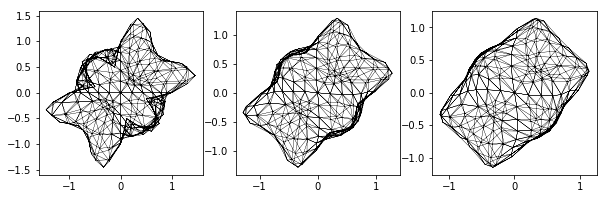

In [4]:
count = 0
t = 0.
end_time = 0.05
scheme.model.dt = 0.005

fig = pyplot.figure(figsize=(10, 10))
plot(solution, figure=(fig, 131+count%3), colorbar=False, 
     gridLines="", triplot=True)

while t < end_time:
    scheme.solve(target=solution)
    t += scheme.model.dt
    count += 1
    positions.dofVector.assign(solution.dofVector)
    if count % 4 == 0:
        plot(solution, figure=(fig, 131+count%3), colorbar=False, 
             gridLines="", triplot=True)
pyplot.show()
pyplot.close('all')

In case we start with a spherical initial surface, i.e., $\Gamma(0)=R_0\;S^2$, the solution
to the mean curvature flow equation is easy to compute:
\begin{align}
  \Gamma(t) &= R(t)\;S^2 \\
  R(t) &= \sqrt{R_0^2-4t}
\end{align}
We can use this to check that our implementation is correct. To do so we first define a function that computes the averaged radius of the surface.

In [5]:
def calcRadius(surface):
    # compute R = int_x |x| / int_x 1
    R   = 0
    vol = 0
    for e in surface.elements:
        rule = geometry.quadratureRule(e.type, 4)
        for p in rule:
            geo = e.geometry
            weight = geo.volume * p.weight
            R   += geo.toGlobal(p.position).two_norm * weight
            vol += weight
    return R/vol

Now we test the convergence rate by solving over a loop, and calculating the error in terms of the difference between the above analytical solution and our calculated one. We plot this in a figure.

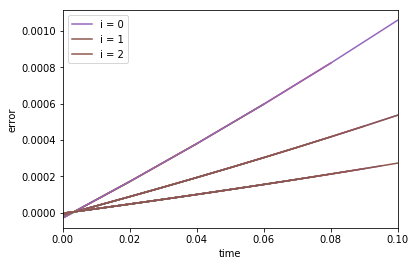

In [6]:
end_time = 0.1
scheme.model.dt = 0.02

import numpy as np
pyplot.figure()
pyplot.gca().set_xlim([0, end_time])
pyplot.gca().set_ylabel("error")
pyplot.gca().set_xlabel("time")

number_of_loops = 3
errors = np.zeros(number_of_loops)
totalIterations = np.zeros(number_of_loops, np.dtype(np.uint32))
gridSizes = np.zeros(number_of_loops, np.dtype(np.uint32))
for i in range(number_of_loops):
    positions.interpolate(lambda x: x * (R0/x.two_norm))
    solution.interpolate(lambda x: x)
    t = 0.
    R = calcRadius(surface)
    Rexact = math.sqrt(R0**2 - 4.*t)
    x = np.array([t])
    y = np.array([R - Rexact])
    iterations = 0
    while t < end_time:
        solution,info = scheme.solve(target=solution)
        # move the surface
        positions.dofVector.assign(solution.dofVector)
        # store some information about the solution process
        iterations += int( info["linear_iterations"] )
        t += scheme.model.dt
        R = calcRadius( surface )
        Rexact = math.sqrt(R0*R0-4.*t)
        x = np.append(x, [t])
        y = np.append(y, [R - Rexact])
        pyplot.plot(x, y, label='i = '+ str(i) if t >= end_time \
                    else '')
        pyplot.legend()
        display.clear_output(wait=True)
        display.display(pyplot.gcf())
    errors[i] = abs(R - Rexact)
    totalIterations[i] = iterations
    gridSizes[i] = grid.size(2)
    if i < number_of_loops - 1:
        grid.hierarchicalGrid.globalRefine(1)
        scheme.model.dt /= 2.

The estimated orders of convergence (EOCs) are calculated as shown.

In [7]:
eocs = np.log(errors[0:][:number_of_loops-1] / errors[1:]) \
              / math.log(2.)
print(eocs)

[ 0.82367854  1.13117264]


Finally we organise this information into a table using ```pandas```.

In [8]:
try:
    import pandas as pd
    keys = {'size': gridSizes, 'error': errors, 
            "eoc": np.insert(eocs, 0, None), 
            'iterations': totalIterations}
    table = pd.DataFrame(keys, index=range(number_of_loops),
                         columns=['size', 'error', 'eoc', 
                                  'iterations'])
    print(table)
except ImportError:
    print("pandas could not be used to show table with results")
    pass

   size     error       eoc  iterations
0   318  0.001060       NaN          80
1   854  0.000599  0.823679         339
2  2065  0.000273  1.131173         777
